In [1]:
import sys
import os

# 获取当前 Notebook 的路径
current_dir = os.path.dirname(os.path.abspath("__file__"))

# 获取上一级目录
parent_dir = os.path.dirname(current_dir)

# 添加上一级目录到 sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils import read_jsonl

In [3]:
import os
import time
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from functools import partial
from eap.metrics import logit_diff
from eap.graph import Graph
from eap.dataset import EAPDataset
from eap.attribute import attribute
from eap.evaluate import evaluate_graph, evaluate_baseline, get_circuit_logits

In [4]:
new_entity_first_token_accuracy = {}

new_entity_first_token_accuracy["1"] = [
    0.917085795, 0.910737829, 0.911616778, 0.920357439, 0.926265931, 0.929244592, 0.932662728, 0.935934372, 0.937399287, 0.940231457, 0.94247766, 0.943014796, 0.94535866, 0.946042287, 0.946725914, 0.94819083, 0.947897847, 0.948532643, 0.949851067, 0.950290542, 0.949558084, 0.950632355, 0.951657796, 0.95302505, 0.952878559, 0.954196982, 0.954148152, 0.953757508, 0.955320084, 0.956931491, 0.956101372, 0.956199033, 0.957126813, 0.957224474, 0.957956931, 0.957468626, 0.957322135, 0.957615118, 0.958933542, 0.959177694, 0.959226525, 0.959568338, 0.960447287, 0.961082084, 0.961375067, 0.961423898, 0.96069144, 0.960740271, 0.961375067, 0.961570389, 0.961814542, 0.961570389, 0.961082084, 0.961277406, 0.961375067, 0.962205186, 0.962254016, 0.962302847, 0.961375067, 0.961961033, 0.962302847
]

new_entity_first_token_accuracy["0.4"] = [
    0.917085795, 0.81595781, 0.591435129, 0.529664534, 0.529664534, 0.582840959, 0.63372235, 0.673470384, 0.717564334, 0.75067142, 0.759900386, 0.767615606, 0.779041945, 0.792372674, 0.803701353, 0.8063382, 0.810488793, 0.816348455, 0.820450217, 0.821329166, 0.829435031, 0.833780946, 0.837199082, 0.838175692, 0.834073929, 0.83607598, 0.846965184, 0.849699692, 0.847648811, 0.84945554, 0.847795303, 0.85135993, 0.858684506, 0.856780116, 0.857366082, 0.86000293, 0.855657015, 0.857512574, 0.863128082, 0.862102642, 0.862444455, 0.864495337, 0.860686557, 0.862395625, 0.868011133, 0.868157625, 0.866106743, 0.867425167, 0.868792422, 0.867327506, 0.871575761, 0.867522828, 0.87059915, 0.870159676, 0.869378388, 0.868743591, 0.873626642, 0.871673422, 0.87250354, 0.871233947, 0.870843303
]

new_entity_first_token_accuracy["0.2"] = [
    0.917085795, 0.797158064, 0.473948923, 0.342643684, 0.266809903, 0.241222716, 0.244885004, 0.255530055, 0.269056106, 0.281947361, 0.295424581, 0.309878412, 0.333170565, 0.353386396, 0.373699888, 0.395087651, 0.417452024, 0.437521363, 0.449728991, 0.457688364, 0.468040432, 0.4812735, 0.497534059, 0.506030568, 0.518335856, 0.538014551, 0.553884467, 0.561062552, 0.556814298, 0.562429806, 0.572684213, 0.579178671, 0.593827824, 0.607744519, 0.606035451, 0.609941892, 0.620489282, 0.621026417, 0.618145417, 0.642609502, 0.646271791, 0.646125299, 0.652424435, 0.657551638, 0.660872113, 0.65867474, 0.674251672, 0.674837639, 0.680453147, 0.67405635, 0.68362713, 0.692758435, 0.680062503, 0.690268079, 0.69607891, 0.692904927, 0.687924215, 0.709409639, 0.70184091, 0.693783876, 0.701206114
]

new_entity_first_token_accuracy["0.1"] = [
    0.917085795, 0.797158064, 0.473948923, 0.342643684, 0.266809903, 0.241222716, 0.244885004, 0.255530055, 0.269056106, 0.281947361, 0.295424581, 0.309878412, 0.333170565, 0.353386396, 0.373699888, 0.395087651, 0.417452024, 0.437521363, 0.449728991, 0.457688364, 0.468040432, 0.4812735, 0.497534059, 0.506030568, 0.518335856, 0.538014551, 0.553884467, 0.561062552, 0.556814298, 0.562429806, 0.572684213, 0.579178671, 0.593827824, 0.607744519, 0.606035451, 0.609941892, 0.620489282, 0.621026417, 0.618145417, 0.642609502, 0.646271791, 0.646125299, 0.652424435, 0.657551638, 0.660872113, 0.65867474, 0.674251672, 0.674837639, 0.680453147, 0.67405635, 0.68362713, 0.692758435, 0.680062503, 0.690268079, 0.69607891, 0.692904927, 0.687924215, 0.709409639, 0.70184091, 0.693783876, 0.701206114
]

new_entity_first_token_accuracy["0"] = [
    0.917085795, 0.778309488, 0.391620685, 0.243420089, 0.169930172, 0.144342985, 0.135748816, 0.13042629, 0.127789443, 0.123883002, 0.120562527, 0.118658138, 0.116460765, 0.114409883, 0.112456663, 0.110356951, 0.11118707, 0.112261341, 0.112359002, 0.111480053, 0.111284731, 0.10928268, 0.110454612, 0.109526832, 0.110112798, 0.109233849, 0.108794375, 0.109624493, 0.110112798, 0.110796426, 0.109770985, 0.110161629, 0.110747595, 0.109185019, 0.109380341, 0.109624493, 0.110454612, 0.111089409, 0.111577714, 0.109868646, 0.109526832, 0.110991748, 0.113530934, 0.113189121, 0.11118707, 0.110161629, 0.111040578, 0.113384443, 0.113726256, 0.112407832, 0.111870697, 0.112359002, 0.111919527, 0.111870697, 0.113628595, 0.114263392, 0.115728307, 0.113237951, 0.116070121, 0.115532985, 0.114165731
]

In [5]:
len(new_entity_first_token_accuracy["1"]), len(new_entity_first_token_accuracy["0.4"]), len(new_entity_first_token_accuracy["0.2"]), len(new_entity_first_token_accuracy["0.1"])

(61, 61, 61, 61)

In [6]:
revised_entity_first_token_accuracy = {}

revised_entity_first_token_accuracy["1"] = [
    0.933618844, 0.929920187, 0.927194861, 0.936538836, 0.942573486, 0.946077477, 0.950165466, 0.951722795, 0.952696126, 0.954448121, 0.956200117, 0.956784115, 0.956589449, 0.958146778, 0.958536111, 0.960288106, 0.96106677, 0.960482772, 0.962429434, 0.962234767, 0.961261437, 0.96106677, 0.962234767, 0.961261437, 0.962429434, 0.9626241, 0.964181429, 0.963208098, 0.964376095, 0.965349426, 0.965933424, 0.96515476, 0.966322756, 0.965738758, 0.966712089, 0.965738758, 0.967490753, 0.96768542, 0.967296087, 0.967490753, 0.968269418, 0.968269418, 0.968464084, 0.967880086, 0.968074752, 0.968269418, 0.969242749, 0.969826747, 0.970800078, 0.970410746, 0.969826747, 0.970410746, 0.970216079, 0.971384076, 0.970800078, 0.971384076, 0.970800078, 0.970605412, 0.970605412, 0.97118941, 0.971773409
]

revised_entity_first_token_accuracy["0.4"] = [
    0.933618844, 0.875413666, 0.724352735, 0.680552852, 0.715203426, 0.779832587, 0.808643177, 0.829667121, 0.859645708, 0.878138992, 0.889234962, 0.897994939, 0.906754915, 0.912400234, 0.916293557, 0.919992213, 0.922717539, 0.925442865, 0.930114853, 0.929920187, 0.932450847, 0.934981507, 0.935565505, 0.935565505, 0.936538836, 0.936928168, 0.937512167, 0.94140549, 0.942768153, 0.942768153, 0.94140549, 0.940626825, 0.940821491, 0.943352151, 0.942573486, 0.944130816, 0.944714814, 0.94490948, 0.944520148, 0.945298813, 0.946077477, 0.946272143, 0.945493479, 0.945298813, 0.945882811, 0.946661476, 0.946661476, 0.947829472, 0.947050808, 0.947829472, 0.945298813, 0.946466809, 0.945493479, 0.944714814, 0.944325482, 0.946661476, 0.947050808, 0.948413471, 0.948413471, 0.946272143, 0.945882811
]

revised_entity_first_token_accuracy["0.2"] = [
    0.933618844, 0.863539031, 0.624683668, 0.501070664, 0.424177536, 0.416001557, 0.442086821, 0.480436052, 0.512945299, 0.550321199, 0.581467783, 0.611835702, 0.645512945, 0.676464863, 0.700798131, 0.72766206, 0.754525988, 0.773019272, 0.798715203, 0.8125365, 0.824216469, 0.837843099, 0.850301733, 0.858283045, 0.865485692, 0.869963013, 0.879306989, 0.882810979, 0.88631497, 0.888456297, 0.89137629, 0.896242943, 0.898384271, 0.900330932, 0.900914931, 0.901109597, 0.906365583, 0.905781585, 0.909480241, 0.910842904, 0.915514892, 0.916682889, 0.914930894, 0.915514892, 0.916293557, 0.91862955, 0.919213549, 0.920770878, 0.920576212, 0.922133541, 0.922912206, 0.920770878, 0.921549543, 0.921549543, 0.923106872, 0.922328207, 0.922717539, 0.921549543, 0.923496204, 0.922912206, 0.922328207
]

revised_entity_first_token_accuracy["0.1"] = [
    0.933618844, 0.855947051, 0.580689118, 0.419116216, 0.32995912, 0.287911232, 0.276815262, 0.272727273, 0.270585945, 0.267081954, 0.265719291, 0.265524625, 0.263577964, 0.280124586, 0.296281877, 0.306404516, 0.313996496, 0.338135098, 0.367724353, 0.390305626, 0.418532217, 0.45376679, 0.488417364, 0.51138797, 0.539419895, 0.580494452, 0.615145026, 0.643955616, 0.671403543, 0.692816819, 0.711699435, 0.720848744, 0.748102005, 0.764648628, 0.778469924, 0.787619233, 0.796573876, 0.803581857, 0.810589838, 0.820907144, 0.825579132, 0.830445785, 0.832392447, 0.835507105, 0.840179093, 0.844267082, 0.847187074, 0.853027059, 0.853611057, 0.860229706, 0.859451041, 0.863539031, 0.866264357, 0.867043021, 0.868016352, 0.873077672, 0.874245669, 0.87366167, 0.875608332, 0.875024333, 0.878333658
]

revised_entity_first_token_accuracy["0"] = [
    0.933618844, 0.852832392, 0.537862566, 0.35370839, 0.251897995, 0.201284797, 0.181818182, 0.168191551, 0.15612225, 0.143858283, 0.1374343, 0.135876971, 0.13139965, 0.129452988, 0.127116994, 0.126532996, 0.125364999, 0.124391668, 0.122250341, 0.122250341, 0.120693011, 0.122639673, 0.122834339, 0.117773019, 0.120693011, 0.121082344, 0.11874635, 0.120887678, 0.122250341, 0.122834339, 0.119914347, 0.120498345, 0.120693011, 0.11874635, 0.121082344, 0.12127701, 0.119135682, 0.124002336, 0.124197002, 0.123613004, 0.120693011, 0.125170333, 0.127700993, 0.12886899, 0.124002336, 0.123029005, 0.125170333, 0.128090325, 0.126922328, 0.124586334, 0.125364999, 0.129258322, 0.130620985, 0.130426319, 0.131983648, 0.133151645, 0.130231653, 0.130620985, 0.135292973, 0.138602297, 0.136655636
]

In [7]:
acc_coords = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300])

In [8]:
directory_path = {}
subdirectories = {}
ratio_list = ["0", "0.1", "0.2", "0.4", "1"]
for replay_ratio in ratio_list:
    directory_path[replay_ratio]=f"../outputs/forget/gpt2/replay_{replay_ratio}/checkpoints"
    subdirectories[replay_ratio] = [
        name for name in os.listdir(directory_path[replay_ratio])
        if os.path.isdir(os.path.join(directory_path[replay_ratio], name))
    ]

In [9]:
new_entity_result_matrix = {}
revised_entity_result_matrix = {}
for replay_ratio in ratio_list:
    new_entity_result_matrix[replay_ratio] = []
    revised_entity_result_matrix[replay_ratio] = []
    to_delete = []
    for dir_name in subdirectories[replay_ratio]:
        prediction_file = os.path.join(directory_path[replay_ratio], dir_name, "prediction.jsonl")
        if not os.path.exists(prediction_file):
            print(f"Prediction file not found for directory '{dir_name}'")
            to_delete.append(dir_name)
        else:
            print(f"Reading prediction file for directory '{dir_name}'")
            predictions = read_jsonl(prediction_file)
            N = len(predictions)
            new_entity_num = int(0.5 * N)
            new_entity_result = [pred["correct"] for pred in predictions][:new_entity_num]
            new_entity_result_matrix[replay_ratio].append(new_entity_result)
            revised_entity_result = [pred["correct"] for pred in predictions][new_entity_num:]
            revised_entity_result_matrix[replay_ratio].append(revised_entity_result)

    # for dir_name in to_delete:
    #     subdirectories[replay_ratio].remove(dir_name)

Reading prediction file for directory 'checkpoint-285'
Reading prediction file for directory 'checkpoint-221'
Reading prediction file for directory 'checkpoint-1'
Reading prediction file for directory 'checkpoint-189'
Reading prediction file for directory 'checkpoint-93'
Reading prediction file for directory 'checkpoint-3'
Reading prediction file for directory 'checkpoint-9'
Reading prediction file for directory 'checkpoint-157'
Reading prediction file for directory 'checkpoint-29'
Reading prediction file for directory 'checkpoint-5'
Reading prediction file for directory 'checkpoint-125'
Reading prediction file for directory 'checkpoint-13'
Reading prediction file for directory 'checkpoint-61'
Reading prediction file for directory 'checkpoint-45'
Reading prediction file for directory 'checkpoint-253'
Reading prediction file for directory 'checkpoint-21'
Reading prediction file for directory 'checkpoint-285'
Reading prediction file for directory 'checkpoint-221'
Reading prediction file 

In [10]:
indexes = {}
for replay_ratio in ratio_list:
    indexes[replay_ratio] = sorted(range(len(subdirectories[replay_ratio])), key=lambda i: int(subdirectories[replay_ratio][i].split('-')[1]))
    print("排序后的下标列表：", indexes[replay_ratio])

排序后的下标列表： [2, 5, 9, 6, 11, 15, 8, 13, 12, 4, 10, 7, 3, 1, 14, 0]
排序后的下标列表： [2, 5, 9, 6, 11, 15, 8, 13, 12, 4, 10, 7, 3, 1, 14, 0]
排序后的下标列表： [2, 5, 9, 6, 11, 15, 8, 13, 12, 4, 10, 7, 3, 1, 14, 0]
排序后的下标列表： [2, 5, 9, 6, 11, 15, 8, 13, 12, 4, 10, 7, 3, 1, 14, 0]
排序后的下标列表： [2, 5, 9, 6, 11, 15, 8, 13, 12, 4, 10, 7, 3, 1, 14, 0]


In [11]:
for replay_ratio in ratio_list:
    new_entity_result_matrix[replay_ratio] = [new_entity_result_matrix[replay_ratio][i] for i in indexes[replay_ratio]]
    new_entity_result_matrix[replay_ratio] = np.array(new_entity_result_matrix[replay_ratio])
    revised_entity_result_matrix[replay_ratio] = [revised_entity_result_matrix[replay_ratio][i] for i in indexes[replay_ratio]]
    revised_entity_result_matrix[replay_ratio] = np.array(revised_entity_result_matrix[replay_ratio])

In [12]:
new_entity_accuracy = {}
revised_entity_accuracy = {}
for replay_ratio in ratio_list:
    new_entity_accuracy[replay_ratio] = np.mean(new_entity_result_matrix[replay_ratio], axis=1)
    revised_entity_accuracy[replay_ratio] = np.mean(revised_entity_result_matrix[replay_ratio], axis=1)

In [13]:
x_coords = np.array([1, 3, 5, 9, 13, 21, 29, 45, 61, 93, 125, 157, 189, 221, 253, 285])

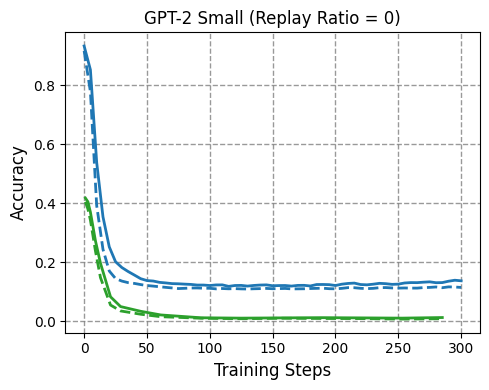

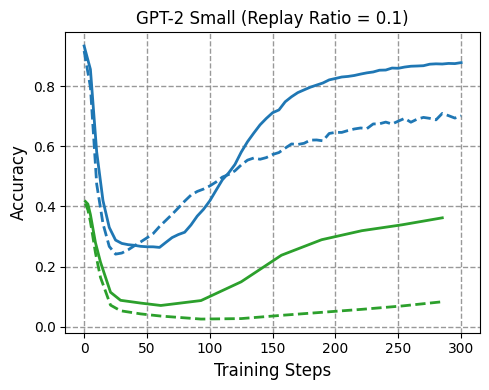

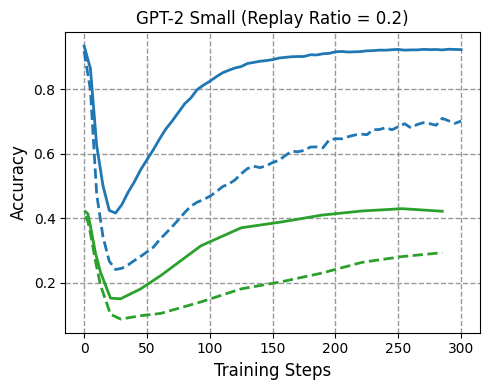

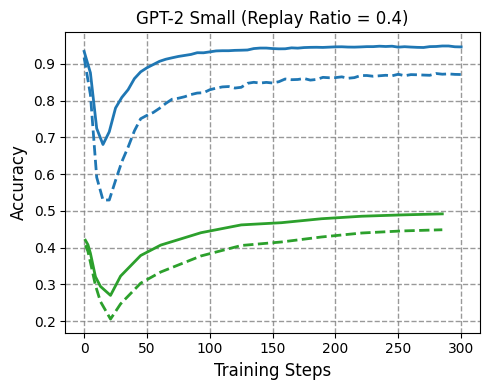

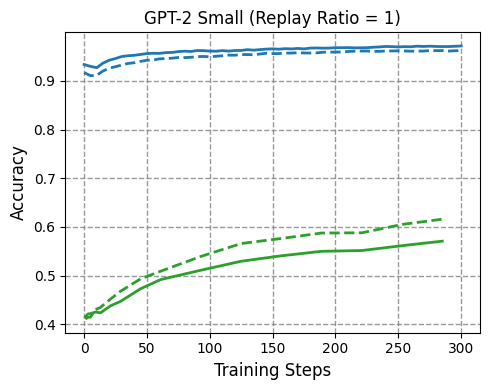

In [14]:
for replay_ratio in ratio_list:
    plt.figure(figsize=(5, 4))
    plt.plot(acc_coords, revised_entity_first_token_accuracy[replay_ratio], label='First-token Acc (K_rel)', linewidth=2, color='C0')
    plt.plot(acc_coords, new_entity_first_token_accuracy[replay_ratio], label='First-token Acc (K_compl)', linewidth=2, color='C0', linestyle='--')
    plt.plot(x_coords, revised_entity_accuracy[replay_ratio], label=f'Query Acc (K_rel)', linewidth=2, color=f'C2')
    plt.plot(x_coords, new_entity_accuracy[replay_ratio], label=f'Quey Acc (K_compl)', linewidth=2, color=f'C2', linestyle='--')
    
    plt.title(f'GPT-2 Small (Replay Ratio = {replay_ratio})')
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    # plt.legend(loc='best', frameon=True, framealpha=0.9)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)
    
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

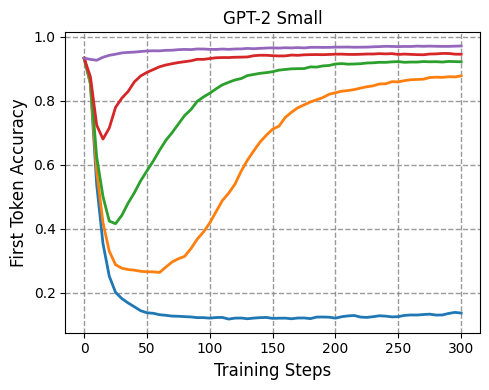

In [19]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

for i, replay_ratio in enumerate(ratio_list):
    plt.plot(acc_coords, revised_entity_first_token_accuracy[replay_ratio], label=f'Replay Ratio = {replay_ratio}', linewidth=2, color=f'C{i}')

# Set titles and labels
plt.title(f'GPT-2 Small')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('First Token Accuracy', fontsize=12)
# plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [16]:
def reduce_array(arr, n):
    """
    将有序数组的元素减少到 n 个，均匀删减元素。

    参数:
    - arr: 原始有序数组
    - n: 缩减后的元素数量

    返回:
    - 新的缩减后数组
    """
    N = len(arr)
    if n >= N:
        return arr  # 如果需要的元素数量大于或等于原数组数量，则返回原数组

    # 计算步长 step，确保均匀删减
    step = N / n

    # 保留均匀分布的 n 个元素
    reduced_arr = [arr[int(i * step)] for i in range(n)]

    return reduced_arr

In [18]:
from collections import defaultdict

def create_performance_dict():
    # 使用 lambda 递归创建嵌套字典结构
    return defaultdict(lambda: {"high": [], "medium": [], "low": []})

clean_baseline_performance = {}
circuit_performance = {}
corrupted_baseline_performance = {}
faithfulness_performance = {}
edge_entropy = {}
graph = {}
for replay_ratio in ratio_list:
# 使用函数创建相同结构的嵌套字典
    clean_baseline_performance[replay_ratio] = create_performance_dict()
    circuit_performance[replay_ratio] = create_performance_dict()
    corrupted_baseline_performance[replay_ratio] = create_performance_dict()
    faithfulness_performance[replay_ratio] = create_performance_dict()
    edge_entropy[replay_ratio] = create_performance_dict()
    graph[replay_ratio] = create_performance_dict()

    task = "city"
    topn = 5000
    circuit_n = 300
    for index in tqdm(indexes[replay_ratio]):
        for type in ["new", "revised"]:
            for freq in ["high", "medium", "low"]:
                result_file = os.path.join(directory_path[replay_ratio], subdirectories[replay_ratio][index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_{topn}", f"{task}_results.json")
                if os.path.exists(result_file):
                    results = json.load(open(result_file))
                    clean_baseline_performance[replay_ratio][type][freq].append(results["clean_baseline_performance"])
                    circuit_performance[replay_ratio][type][freq].append(results["circuit_performance"])
                    corrupted_baseline_performance[replay_ratio][type][freq].append(results["corrupted_baseline_performance"])
                    faithfulness = (results["circuit_performance"] - results["corrupted_baseline_performance"]) / (results["clean_baseline_performance"] - results["corrupted_baseline_performance"]) if results["clean_baseline_performance"] > results["corrupted_baseline_performance"] else 0
                    faithfulness_performance[replay_ratio][type][freq].append(faithfulness)
                    edge_entropy[replay_ratio][type][freq].append(results["edge_entropy"])
                    g = Graph.from_pt(os.path.join(directory_path[replay_ratio], subdirectories[replay_ratio][index], f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_{topn}", f"{task}_graph.pt"))
                    graph[replay_ratio][type][freq].append(g)
                else:
                    print(f"Result file '{result_file}' not found for directory '{subdirectories[index]}'")
                    clean_baseline_performance[replay_ratio][type][freq].append(None)
                    circuit_performance[replay_ratio][type][freq].append(None)
                    corrupted_baseline_performance[replay_ratio][type][freq].append(None)
                    faithfulness_performance[replay_ratio][type][freq].append(None)
                    edge_entropy[replay_ratio][type][freq].append(None)
                    graph[replay_ratio][type][freq].append(None)
            

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:42<00:00,  2.64s/it]


In [20]:
original_g = create_performance_dict()

for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        path = os.path.join("/mnt/8t/oyx/KCPT/outputs/train/gpt2/2024-12-19-22-27-33/checkpoints/checkpoint-2025", f"circuit_{circuit_n}", f"type_{type}", f"frequency_{freq}", "method_EAP-IG", f"topn_5000", f"{task}_graph.pt")
        print(path)
        original_g[type][freq] = Graph.from_pt(path)

/mnt/8t/oyx/KCPT/outputs/train/gpt2/2024-12-19-22-27-33/checkpoints/checkpoint-2025/circuit_300/type_new/frequency_high/method_EAP-IG/topn_5000/city_graph.pt
/mnt/8t/oyx/KCPT/outputs/train/gpt2/2024-12-19-22-27-33/checkpoints/checkpoint-2025/circuit_300/type_new/frequency_medium/method_EAP-IG/topn_5000/city_graph.pt
/mnt/8t/oyx/KCPT/outputs/train/gpt2/2024-12-19-22-27-33/checkpoints/checkpoint-2025/circuit_300/type_new/frequency_low/method_EAP-IG/topn_5000/city_graph.pt
/mnt/8t/oyx/KCPT/outputs/train/gpt2/2024-12-19-22-27-33/checkpoints/checkpoint-2025/circuit_300/type_revised/frequency_high/method_EAP-IG/topn_5000/city_graph.pt
/mnt/8t/oyx/KCPT/outputs/train/gpt2/2024-12-19-22-27-33/checkpoints/checkpoint-2025/circuit_300/type_revised/frequency_medium/method_EAP-IG/topn_5000/city_graph.pt
/mnt/8t/oyx/KCPT/outputs/train/gpt2/2024-12-19-22-27-33/checkpoints/checkpoint-2025/circuit_300/type_revised/frequency_low/method_EAP-IG/topn_5000/city_graph.pt


In [21]:
def jaccard_similarity(a, b):
    """
    计算两个集合的 Jaccard 相似度。

    参数:
    - a: 集合 a
    - b: 集合 b

    返回:
    - Jaccard 相似度
    """
    set_a = set()
    for key, value in a.items():
        if value.in_graph:
             set_a.add(key)
    set_b = set()
    for key, value in b.items():
        if value.in_graph:
             set_b.add(key)
    return len(set_a & set_b) / len(set_a | set_b)

In [22]:
def set_similarity(a, b):
    return len(a & b) / len(a | b)

In [23]:
nodes_last_jaccard_similarity = {}

for replay_ratio in ratio_list:
    nodes_last_jaccard_similarity[replay_ratio] = create_performance_dict()
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            for i in range(len(indexes[replay_ratio])):
                nodes_last_jaccard_similarity[replay_ratio][type][freq].append(jaccard_similarity(graph[replay_ratio][type][freq][i].nodes, original_g[type][freq].nodes))

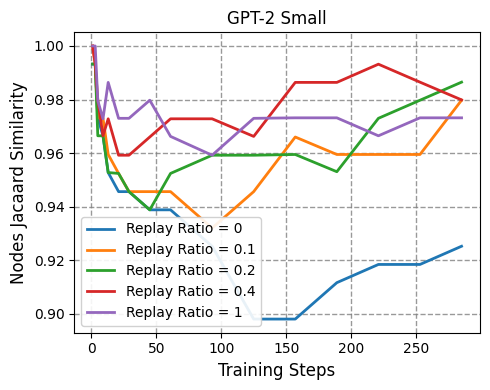

In [24]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed
cnt = 0
for i, replay_ratio in enumerate(ratio_list):
# for type in ["new", "revised"]:
#     for freq in ["high", "medium", "low"]:
    type = "new"
    freq = "medium"
    plt.plot(x_coords, nodes_last_jaccard_similarity[replay_ratio][type][freq], label=f'Replay Ratio = {replay_ratio}', linewidth=2, color=f'C{i}')
        # cnt += 1

# Set titles and labels
plt.title(f'GPT-2 Small')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Nodes Jacaard Similarity', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [25]:
edges_last_jaccard_similarity = {}

for replay_ratio in ratio_list:
    edges_last_jaccard_similarity[replay_ratio] = create_performance_dict()
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            for i in range(len(indexes[replay_ratio])):
                edges_last_jaccard_similarity[replay_ratio][type][freq].append(jaccard_similarity(graph[replay_ratio][type][freq][i].edges, original_g[type][freq].edges))

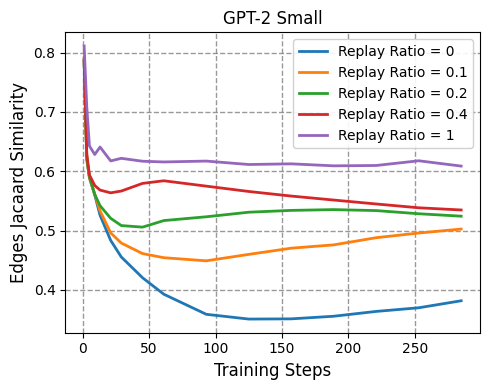

In [38]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed
cnt = 0
for i, replay_ratio in enumerate(ratio_list):
# for type in ["new", "revised"]:
#     for freq in ["high", "medium", "low"]:
    type = "new"
    freq = "high"
    plt.plot(x_coords, edges_last_jaccard_similarity[replay_ratio][type][freq], label=f'Replay Ratio = {replay_ratio}', linewidth=2, color=f'C{i}')
        # cnt += 1

# Set titles and labels
plt.title(f'GPT-2 Small')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Edges Jacaard Similarity', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [27]:
import math

def calculate_entropy(g):
    # 获取所有边的 score 绝对值
    scores = [abs(edge.score) for edge in g.edges.values() if edge.in_graph]
    
    # 如果没有有效的 score 值，返回 None
    if not scores:
        return None
    
    # 归一化 score 值以生成概率分布
    total_score = sum(scores)
    probabilities = [score / total_score for score in scores]

    # 根据 Shannon 公式计算熵
    edge_entropy = -sum(p * math.log(p) for p in probabilities if p > 0)
    
    return edge_entropy

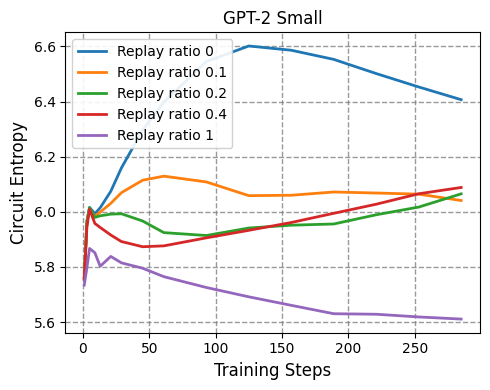

In [28]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
# epochs = np.arange(len(clean_baseline_performance["new"]["high"]))  # Adjust if necessary

part_edge_entropy = {}

cnt = 0
for i, replay_ratio in enumerate(ratio_list):
# for type in ["new", "revised"]:
#     for freq in ["high", "medium", "low"]:
    type = "new"
    freq = "high"
    part_edge_entropy[replay_ratio] = create_performance_dict()
    for j in range(len(indexes[replay_ratio])):
        part_edge_entropy[replay_ratio][type][freq].append(calculate_entropy(graph[replay_ratio][type][freq][j]))
    plt.plot(x_coords, part_edge_entropy[replay_ratio][type][freq], label=f'Replay ratio {replay_ratio}', linewidth=2, color=f'C{i}')
        # cnt += 1

# Set titles and labels
plt.title(f'GPT-2 Small')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Circuit Entropy', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

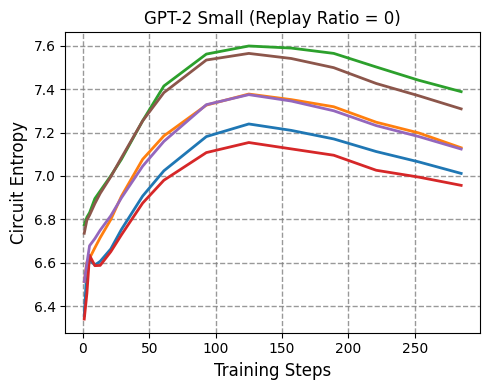

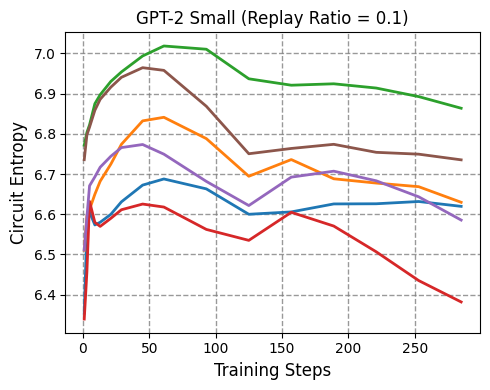

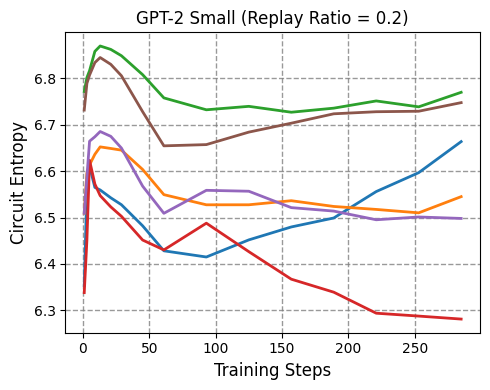

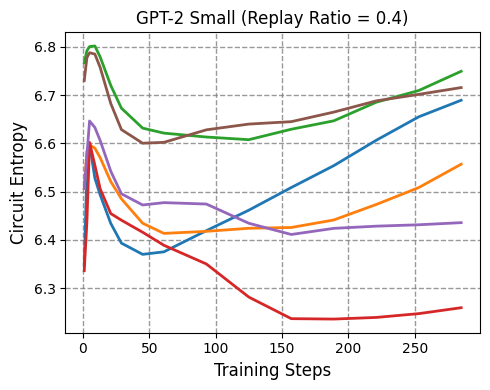

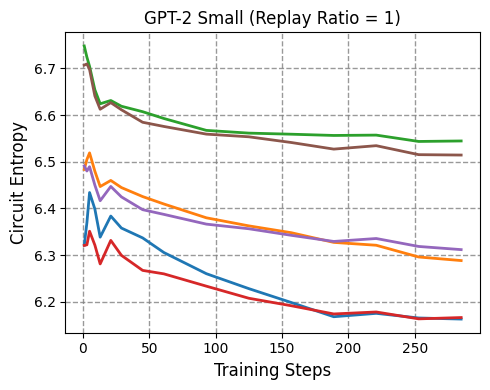

In [29]:
for i, replay_ratio in enumerate(ratio_list):
    plt.figure(figsize=(5, 4))
    cnt = 0
    for type in ["new", "revised"]:
        for freq in ["high", "medium", "low"]:
            plt.plot(x_coords, edge_entropy[replay_ratio][type][freq], label=f'{freq.capitalize()} Freq {type.capitalize()} Entities', linewidth=2, color=f'C{cnt}')
            cnt += 1

    # Set titles and labels
    plt.title(f'GPT-2 Small (Replay Ratio = {replay_ratio})')
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Circuit Entropy', fontsize=12)
    # plt.legend(loc='best', frameon=True, framealpha=0.9)
    plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.8)

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

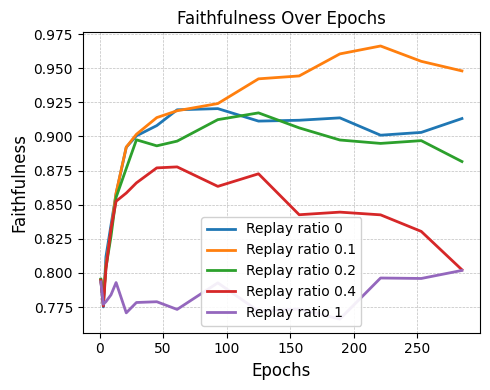

In [30]:
# Set the figure size to increase x-axis width
plt.figure(figsize=(5, 4))  # Adjust width and height as needed

# Assuming `epochs` is the x-axis variable that defines the number of epochs
# epochs = np.arange(len(clean_baseline_performance["new"]["high"]))  # Adjust if necessary
    
for i, replay_ratio in enumerate(ratio_list):
# for type in ["new", "revised"]:
#     for freq in ["high", "medium", "low"]:
    type = "new"
    freq = "high"
    plt.plot(x_coords, faithfulness_performance[replay_ratio][type][freq], label=f'Replay ratio {replay_ratio}', linewidth=2, color=f'C{i}')
        # cnt += 1

# Set titles and labels
plt.title(f'Faithfulness Over Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Faithfulness', fontsize=12)
plt.legend(loc='best', frameon=True, framealpha=0.9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [31]:
def count_edges_at_layers(g, activated=True):
    counter = [0 for i in range(g.cfg["n_layers"] )]
    for edge in g.edges.values():
        if activated and not edge.in_graph:
            continue
        counter[edge.parent.layer] += 1
    
    return counter

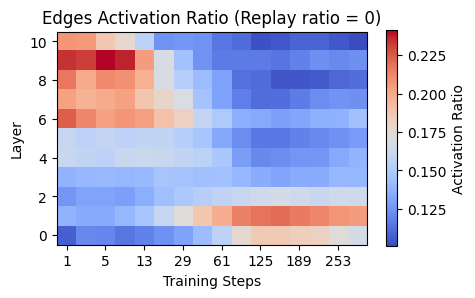

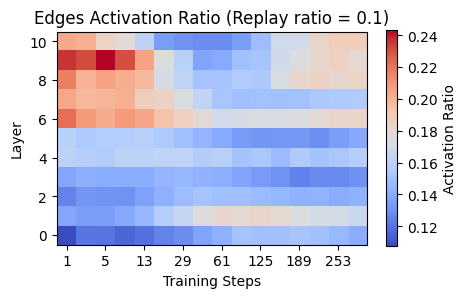

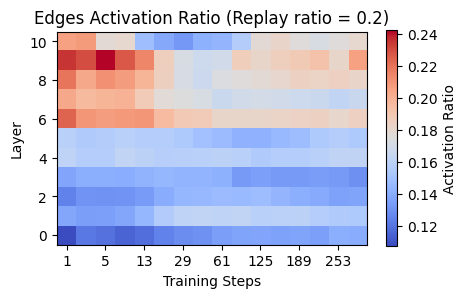

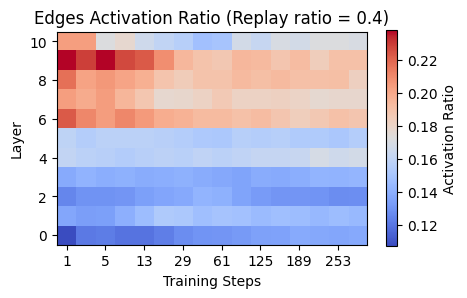

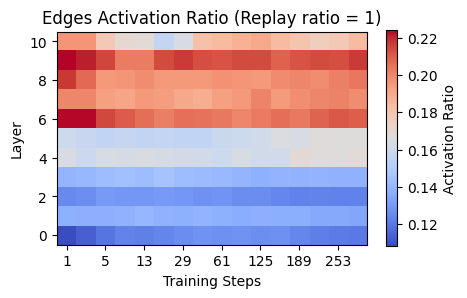

In [32]:
for replay_ratio in ratio_list:
    layer_distribution_matrix = []
    for i in range(len(indexes[replay_ratio])):
        layer_distribution = np.array(count_edges_at_layers(graph[replay_ratio][type][freq][i], activated=True)) / np.array(count_edges_at_layers(graph[replay_ratio][type][freq][i], activated=False))
        layer_distribution_matrix.append(layer_distribution[:-1])

    layer_distribution_matrix = np.array(layer_distribution_matrix)

    # Set the figure size to increase x-axis width
    plt.figure(figsize=(5,4))  # Adjust width and height as needed

    im = plt.imshow(layer_distribution_matrix.T, cmap='coolwarm', interpolation='nearest')
    plt.title(f'Edges Activation Ratio (Replay ratio = {replay_ratio})')
    plt.ylabel('Layer')
    plt.xlabel('Training Steps')
    cbar = plt.colorbar(im, shrink=0.7)
    cbar.set_label('Activation Ratio')
    # 反转 y 轴
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(0, 12, 2))
    plt.xticks(np.arange(0, layer_distribution_matrix.shape[0], 2), labels=x_coords[::2])
    plt.show()


In [33]:
from collections import defaultdict


model = "gpt2"
task = "city"
data = create_performance_dict()
        
task_data = read_jsonl(f"/mnt/8t/oyx/KCPT/data/entities_50000/circuit_300/{model}/{task}.jsonl")
for type in ["new", "revised"]:
    type_data = [item for item in task_data if item["type"] == type]
    for freq in ["high", "medium", "low"]:
        if freq == "high":
            data[type][freq] = [item for item in type_data if int(item["frequency"]) > 5]
        elif freq == "medium":
            data[type][freq] = [item for item in type_data if 2 <= int(item["frequency"]) <= 5]
        else:
            data[type][freq] = [item for item in type_data if int(item["frequency"]) < 2]

prompt_template = {
    "city": "{} lives in the city of",
    "major": "{} majors in the field of",
    "company": "{} works for the company of"
}

In [34]:
import joblib
target_token_rank_at_last = joblib.load("target_token_rank_at_last.pkl")
target_token_prob = joblib.load("target_token_prob.pkl")

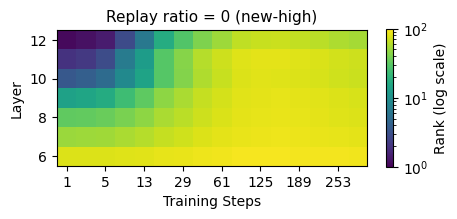

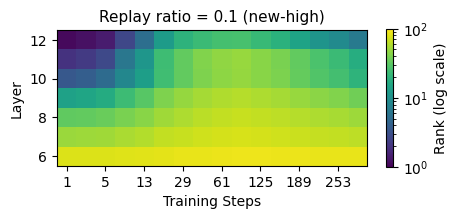

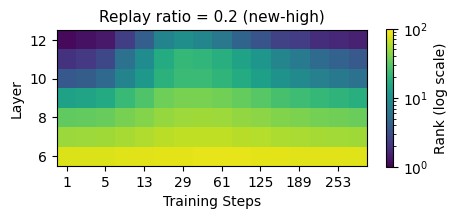

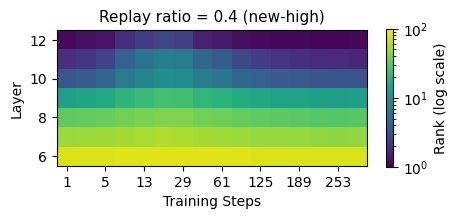

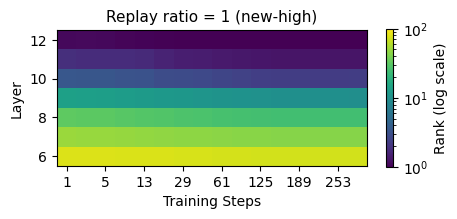

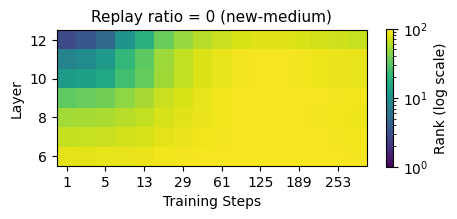

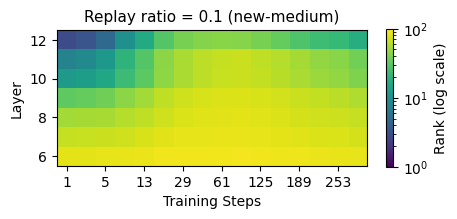

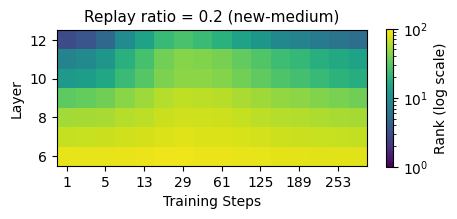

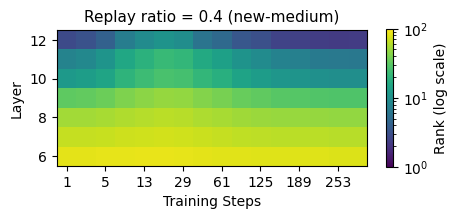

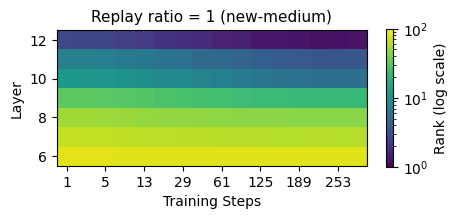

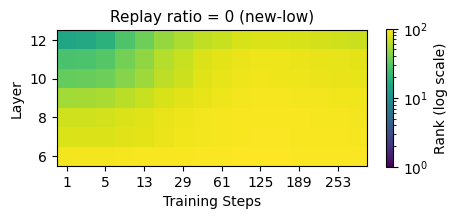

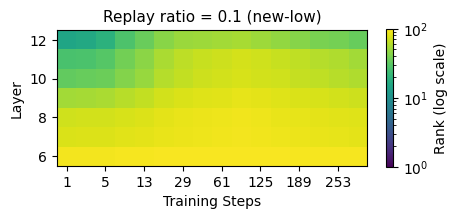

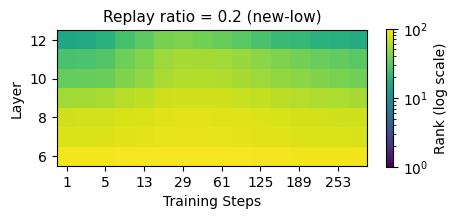

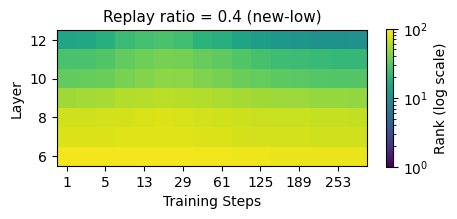

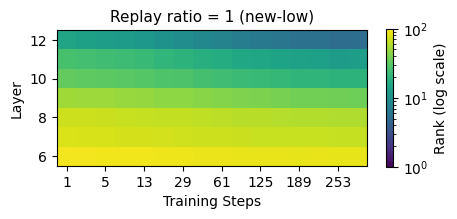

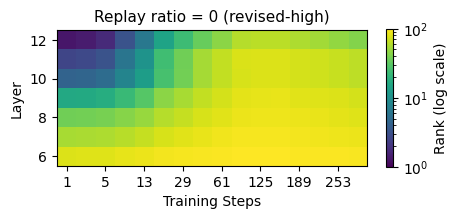

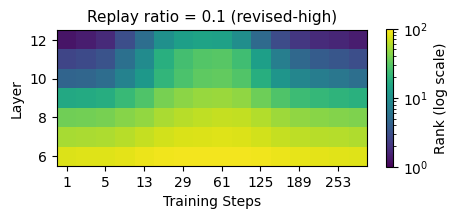

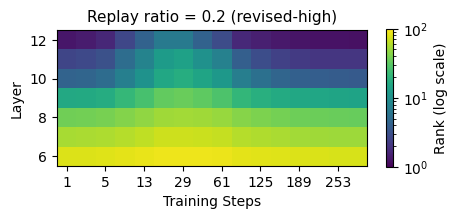

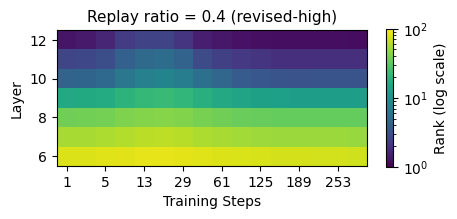

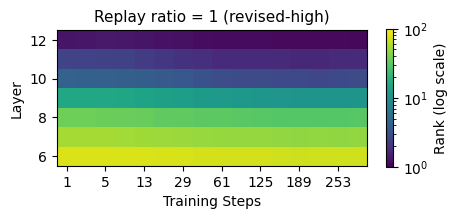

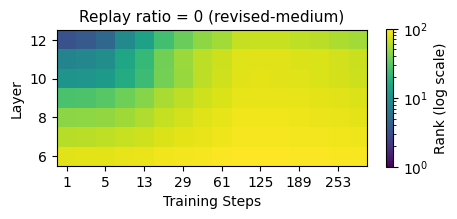

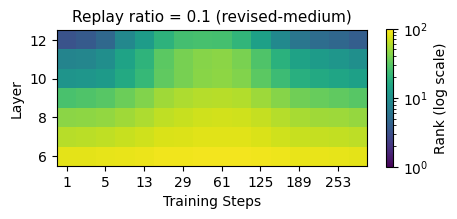

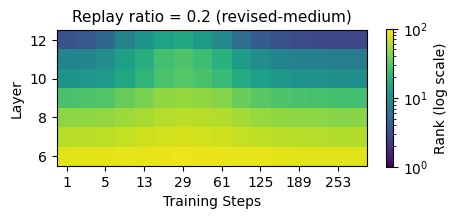

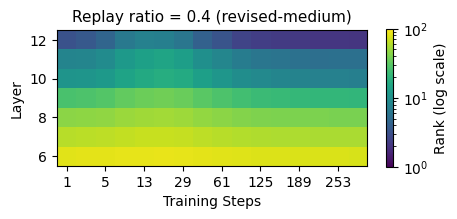

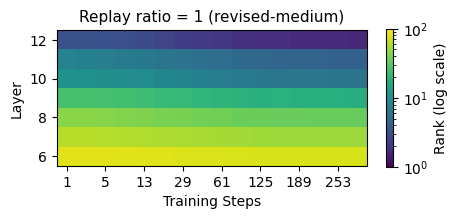

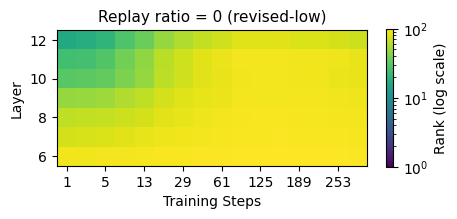

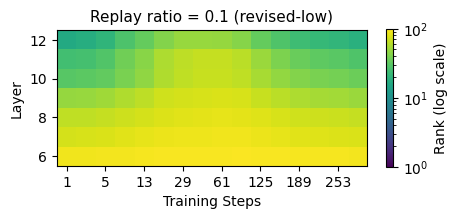

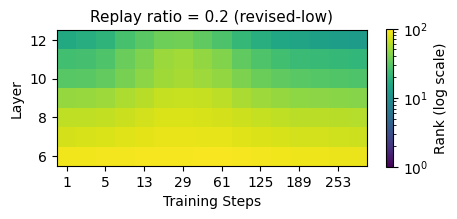

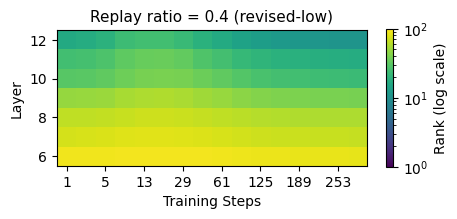

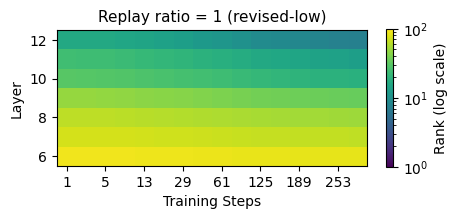

In [35]:
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        for replay_ratio in ratio_list:
            target_token_rank_at_last_matrix = []
            for item in target_token_rank_at_last[replay_ratio][type][freq]:
                target_token_rank_at_last_matrix.append(item)
            target_token_rank_at_last_matrix = np.array(target_token_rank_at_last_matrix)

            # 仅保留后一半的数据
            half_index = target_token_rank_at_last_matrix.shape[1] // 2
            target_token_rank_at_last_matrix_half = target_token_rank_at_last_matrix[:, half_index:]

            # Set the figure size to increase x-axis width
            plt.figure(figsize=(5, 4))  # Adjust width and height as needed

            plt.imshow(
                target_token_rank_at_last_matrix_half.T,
                interpolation='nearest',
                norm=LogNorm(
                    vmin=1,
                    vmax=100
                )
            )
            plt.title(f'Replay ratio = {replay_ratio} ({type}-{freq})', fontsize=11)
            plt.ylabel('Layer')
            plt.xlabel('Training Steps')
            plt.colorbar(shrink=0.45).set_label('Rank (log scale)')
            # 反转 y 轴
            plt.gca().invert_yaxis()

            # 调整 yticks，仅显示后一半对应的范围
            num_layers = target_token_rank_at_last_matrix_half.shape[1]
            plt.yticks(
                np.arange(0, num_layers, 2),  # 每隔2个单位标一个刻度
                labels=np.arange(half_index, half_index + num_layers, 2)  # 标签对应原来的 layer 数值
            )
            plt.xticks(np.arange(0, target_token_rank_at_last_matrix_half.shape[0], 2), labels=x_coords[::2])
            plt.show()

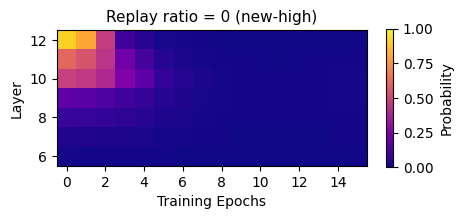

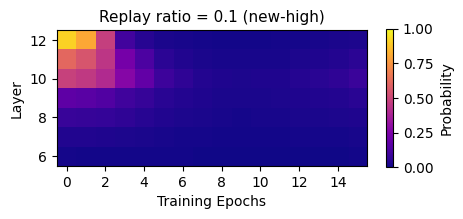

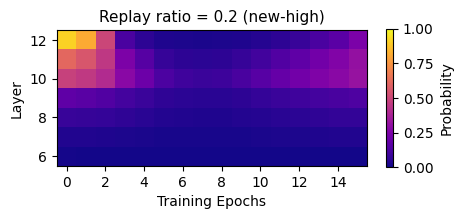

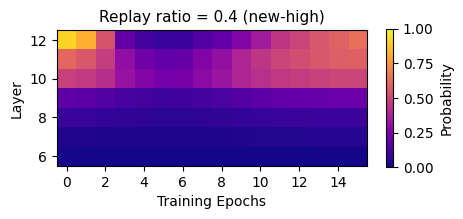

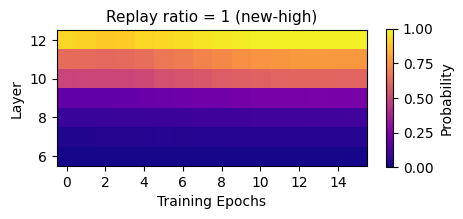

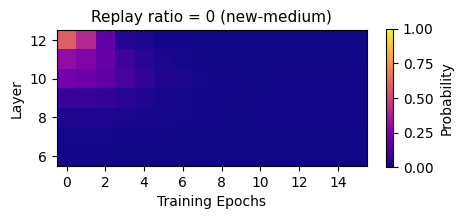

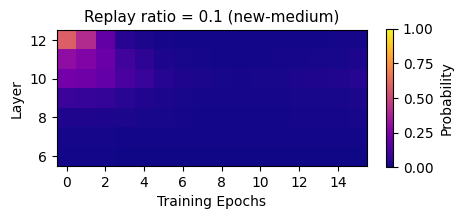

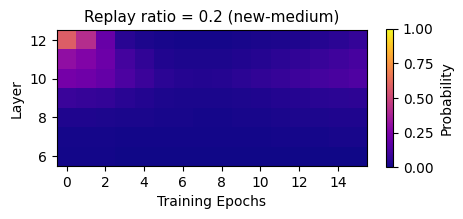

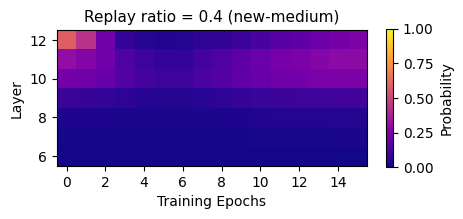

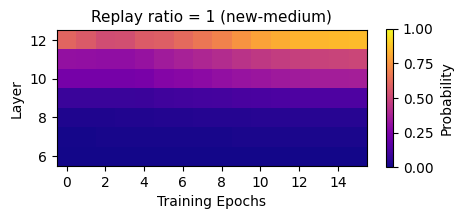

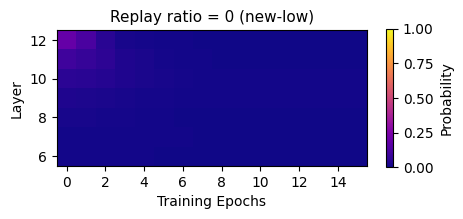

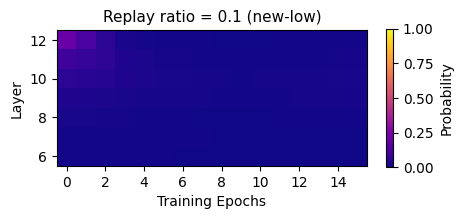

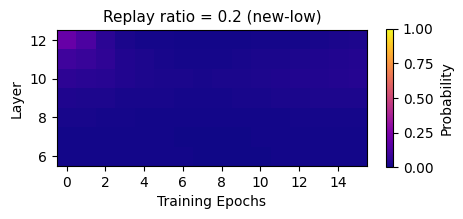

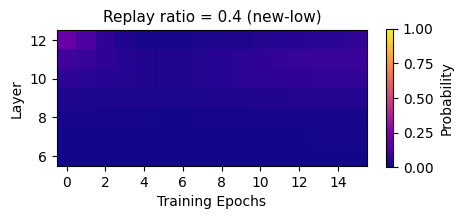

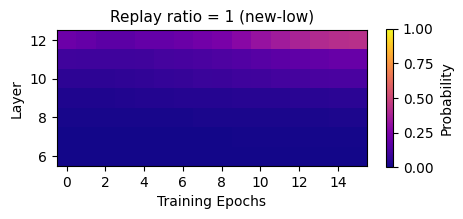

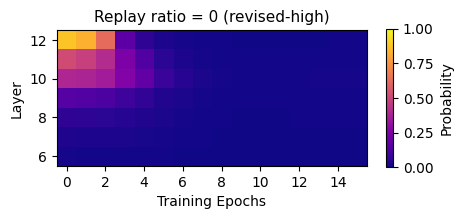

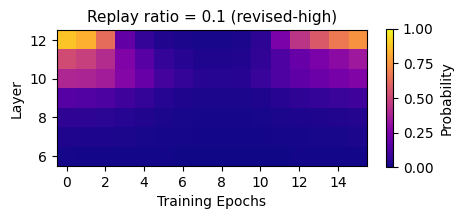

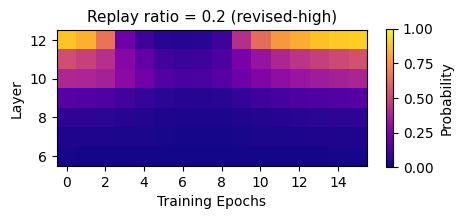

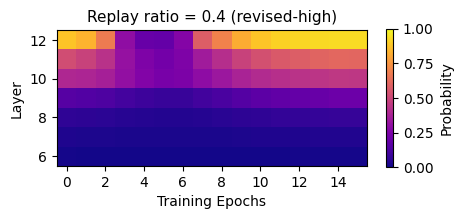

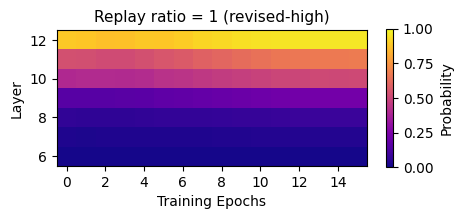

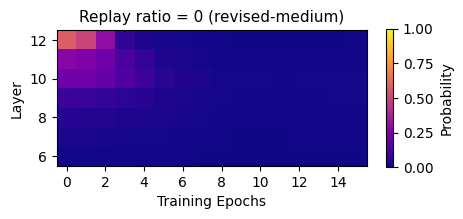

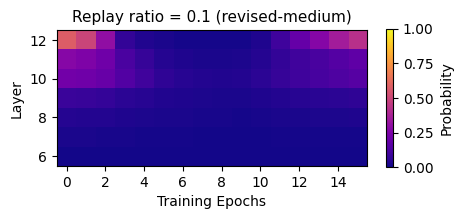

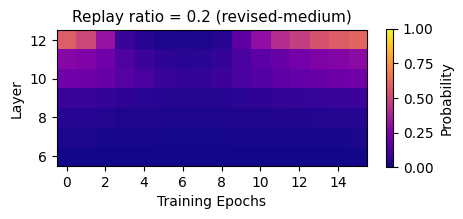

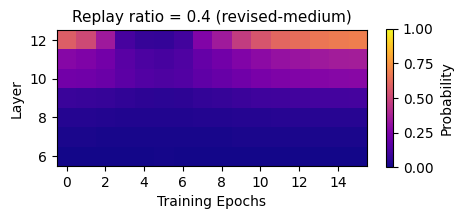

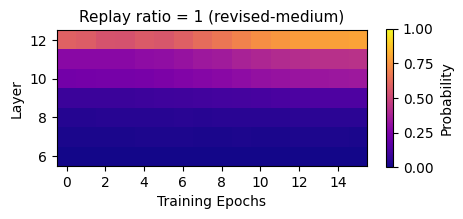

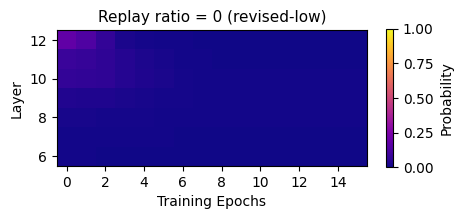

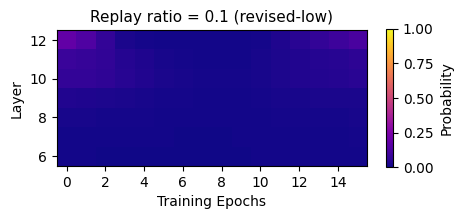

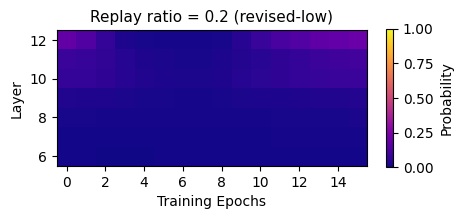

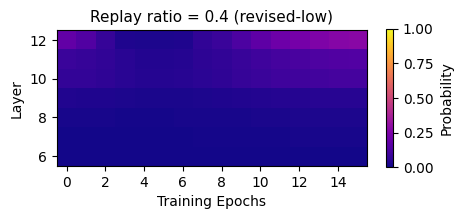

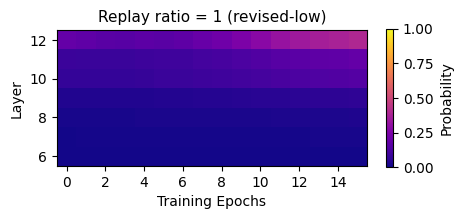

In [36]:
from matplotlib.colors import LogNorm

for type in ["new", "revised"]:
    for freq in ["high", "medium", "low"]:
        for replay_ratio in ratio_list:
            target_token_prob_matrix = []
            for item in target_token_prob[replay_ratio][type][freq]:
                target_token_prob_matrix.append(item)
            target_token_prob_matrix = np.array(target_token_prob_matrix)
            
            # 仅保留后一半的数据
            half_index = target_token_prob_matrix.shape[1] // 2
            target_token_prob_matrix_half = target_token_prob_matrix[:, half_index:]
            
            # Set the figure size to increase x-axis width
            plt.figure(figsize=(5,4))  # Adjust width and height as needed

            plt.imshow(target_token_prob_matrix_half.T, cmap='plasma', interpolation='nearest',vmin=0, vmax=1)
            plt.title(f'Replay ratio = {replay_ratio} ({type}-{freq})', fontsize=11)
            plt.ylabel('Layer')
            plt.xlabel('Training Epochs')
            plt.colorbar(shrink=0.45).set_label('Probability')
            # 反转 y 轴
            plt.gca().invert_yaxis()
            
            # 调整 yticks，仅显示后一半对应的范围
            num_layers = target_token_rank_at_last_matrix_half.shape[1]
            plt.yticks(
                np.arange(0, num_layers, 2),  # 每隔2个单位标一个刻度
                labels=np.arange(half_index, half_index + num_layers, 2)  # 标签对应原来的 layer 数值
            )
            plt.xticks(np.arange(0, target_token_rank_at_last_matrix_half.shape[0], 2))
            plt.show()